# Recommendations with IBM

This notebook goes through the process of making recommendatios to users on articles they might be interested in. It will go through the necessary steps to build a recommendation engine, namely, Rank Based Recommendations, User-User Based Collaborative Filtering, Content Based Recommendations and Matrix Factorization.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download(['punkt', 'wordnet', 'stopwords',
               'averaged_perceptron_tagger'])

import pickle
# Pretty display for notebooks
%matplotlib inline
%config InlineBachend.figure_format = 'retina'


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Loading the datasets

In [2]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In this section, data is being analyzed to observe information which might be useful for the following steps

#### Checking null values

In [4]:
print(df.isnull().sum(), df_content.isnull().sum(), sep='\n\n\n')

article_id     0
title          0
email         17
dtype: int64


doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64


#### Dropping null values and observing the user interaction

In [5]:
# Count user interaction
user_interaction = df.dropna(subset=['email'])

In [6]:
#Observing the amount of titles published by email
user_interaction['email'].value_counts().head()

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: email, dtype: int64

It can be seen that there are 2 outliers in the dataset with considerably higher interactions than the following users. Those 2 users will be dropped for the purpose of creating a distribution visualization

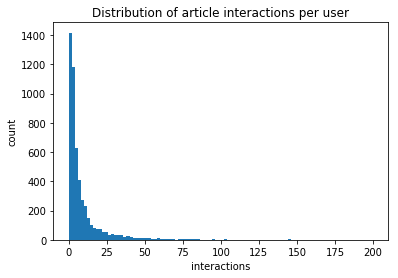

In [7]:
# Distribution of how many articles a user interacts with in the dataset
plt.figure()
plt.hist(user_interaction['email'].value_counts(), bins=100, range=(0,200))
plt.title('Distribution of article interactions per user')
plt.xlabel('interactions')
plt.ylabel('count')
plt.show()

#### Observing median and max

In [8]:
# 50% of individuals interact with ____ number of articles or fewer.
median_val = user_interaction['email'].value_counts().median()
# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = user_interaction['email'].value_counts()[0]
print('50% of individuals interact with {} number of articles or fewer.'.format(int(median_val)))
print('The maximum number of user-article interactions by any 1 user is {}.'.format(int(max_views_by_user)))

50% of individuals interact with 3 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


#### Checking for duplicates in *df_content* and removing them if there are any

In [9]:
# Find and explore duplicate articles
print('No of duplicate values: {}'.format(sum(df_content.article_id.value_counts() > 1)))

No of duplicate values: 5


In [10]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first',inplace=False)

#### Futher observations

In [11]:
unique_articles = df.nunique().article_id
total_articles = df_content.nunique().doc_full_name
unique_users = df.nunique().email
user_article_interactions = df.shape[0]
print('The number of unique articles that have an interaction with a user are {}'.format(unique_articles))
print('The total number of unique articles in the dataset is {}'.format(total_articles))
print('The number of unique users in the dataset is {}'.format(unique_users))
print('The number of user-article interactions in the dataset are {}'.format(user_article_interactions))

The number of unique articles that have an interaction with a user are 714
The total number of unique articles in the dataset is 1051
The number of unique users in the dataset is 5148
The number of user-article interactions in the dataset are 45993


In [12]:
most_viewed_article_id = str(df.article_id.value_counts(dropna=False).head(1).index[0])
print("The most viewed article in the dataset as a string with one value following the decimal is {}".format(most_viewed_article_id))
max_views = df.article_id.value_counts(dropna=False).head(1).values[0]
print("The most viewed article in the dataset was viewed {} times".format(max_views))

The most viewed article in the dataset as a string with one value following the decimal is 1429.0
The most viewed article in the dataset was viewed 937 times


In [13]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    '''
    A method to map the user email to a user_id and remove the email column
    '''
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


#### Passing the tests

In [14]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this section, a number of methods have been built in order to extract the most popular articles, namely:

    get_top_articles - find most popular titles in the dataframe
    
    get_top_article_ids - find most popular title ids in the dataframe

In [15]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_title_count = df.groupby('title')['user_id'].count().sort_values(ascending=False)
    top_articles = article_title_count.head(n).index.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_id_count = df.groupby('article_id')['user_id'].count().sort_values(ascending=False)
    top_articles = article_id_count.head(n).index.tolist()
 
    return top_articles # Return the top article ids

In [16]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


#### Testing the methods

In [17]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


In this section, User-User Based Collaborative filtering will be applied to match user interests and recommend articles to one user based on similar users in the database. This will be done through creating a user-item matrix, then finding the most similar users by getting the dot product.

Furthermore, the algorithm will extend to recommending articles to new users 

#### Creating the matrix

In [18]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id','article_id'])['title'].agg(lambda x: 1).unstack()
    user_item.fillna(0, inplace=True)
    
    return user_item

user_item = create_user_item_matrix(df)

In [19]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Testing the matrix

In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


#### Setting up the algorithms to make recommendations based on similar users

In [21]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_item_dot = user_item.dot(user_item.loc[user_id])
    # sort by similarity
    user_item_dot = user_item_dot.sort_values(ascending=False)
    # create list of just the ids
    most_similar_users = list(user_item_dot.index)
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users
        

#### Check

In [22]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


#### Define methods which return article names that have been seen by a user based from a provided list

In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = df[df.article_id.isin(list(article_ids))].drop_duplicates(subset='article_id').title
        
    
    return article_names 


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    user_row = user_item.loc[user_id]
    article_ids = [str(x) for x in list(user_row[user_row == 1].index)]
    article_names = get_article_names(article_ids)
    return article_ids, article_names
    

def user_user_recs(user_id, m):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    article_seen_ids, article_seen_title = get_user_articles(user_id)
    similar_users = find_similar_users(user_id)
    for user in similar_users:
        if len(recs) < m:
            article_ids, article_names = get_user_articles(user)
            for article_id in article_ids:
                if article_id not in article_seen_ids:
                    recs.append(article_id)
        else:
            break
    
    return recs[:m]    

#### Checking results

In [24]:
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

11      got zip code data? prep it for analytics. – ib...
16      timeseries data analysis of iot events by usin...
125                          graph-based machine learning
322             using brunel in ipython/jupyter notebooks
434                          experience iot with coursera
1432    the 3 kinds of context: machine learning and t...
2655    deep forest: towards an alternative to deep ne...
2677           this week in data science (april 18, 2017)
2680    higher-order logistic regression for large dat...
3093    using machine learning to predict parking diff...
Name: title, dtype: object

In [25]:
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


#### Improving the validity of the recommendation by doing the following:

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions.

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    similarity = user_item.dot(user_item.loc[user_id]).sort_values(ascending=False)
    similarity.drop(user_id, inplace=True)
    similarity = similarity.to_frame('similarity').reset_index()
    
    num_interactions = df.user_id.value_counts().to_frame('num_interactions')
    
    neighbors_df = similarity.merge(num_interactions, left_on='user_id', right_index=True).rename(columns={'user_id':'neighbor_id'})
    
    #sort by similarity, and then by number of interactions
    neighbors_df.sort_values(by=['similarity','num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    rec_names = []
    
    article_seen_ids, article_seen_title = get_user_articles(user_id)
    similar_users_df = get_top_sorted_users(user_id)
    
    for neighbour in similar_users_df['neighbor_id']:
        if len(recs) < m:
            neighbor_article_ids = list(user_item.columns[np.where(user_item.loc[neighbour]==1)])
            for article_id in neighbor_article_ids:
                if article_id not in article_seen_ids:
                    recs.append(article_id)
        else:
            break

    rec_names = get_article_names(recs)
    
    return recs[:m], rec_names[:m]

#### Testing and observing results

In [27]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[12.0, 109.0, 125.0, 142.0, 164.0, 205.0, 232.0, 302.0, 336.0, 362.0]

The top 10 recommendations for user 20 are the following article names:
3             ml optimization using cognitive assistant
4             deploy your python model as a restful api
14             apache spark lab, part 1: basic concepts
16    timeseries data analysis of iot events by usin...
28                                     dsx: hybrid mode
29    predicting churn with the spss random tree alg...
31              analyze energy consumption in buildings
32                   ibm watson facebook posts for 2015
42    use xgboost, scikit-learn & ibm watson machine...
44           apache spark lab, part 3: machine learning
Name: title, dtype: object


In [28]:
# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0]

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[9]

print('The user most similar to user 1 is: {}'.format(user1_most_sim))
print('The 10th most similar user to user 131 is: {}'.format(user131_10th_sim))

The user most similar to user 1 is: 3933
The 10th most similar user to user 131 is: 242


In [29]:
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


#### Futher optimization

One way to improve the recommendations is to apply **Knowledge-Based recommendations**. This can be achieved by either setting up a questionnaire upon registration in order to get an impression of the users taste. Another way would include incorporating filters in the web page and once the user has specified his interests - filter by ranks.

#### Recommending top 10 articles to a new user based on already instantiated methods

In [30]:
#Simulating a new user
new_user = '0.0'

# Simulating top 10 articles to recommend to a new user
new_user_recs = get_top_article_ids(10)



#### Checking the work

In [31]:
assert set(new_user_recs) == set([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some key words. The algorithm will scan through the content of the article and recommend the top articles with similar words. This is an example of **Content-Based Recommentadion**. To achieve this, the article title will be analyzed using natural language processing techniques. Key words will be extracted and converted into their root form. Then similar articles based on the extracted words will be found.  

In [32]:
def tokenize(text):
    """Function to tokenize an article title

    Args:
        text (str) title

    return:
        tokens (list) a list of words

    """

    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words]
    # remove short words
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

In [33]:
def create_article_content_dataframe(df=df, df_content=df_content):
    '''
    INPUT:
    df - initial dataframe provided which gives data on user interactions with articles
    df_content - initial dataframe provided which gives information on articles - name, desc, body etc.
    
    OUTPUT:
    df_merged - A combined dataframe including interactions and full title name
    article_content -  A dataframe which encodes all key words as columns and counts their presence in a title

    '''

    # Merge the 2 datasets
    df_cleaned = df[['article_id', 'title']]
    df_content_cleaned = pd.DataFrame({'article_id': df_content.article_id.values,
                                       'title': df_content. doc_full_name})
    
    df_merged = pd.concat([df_cleaned, df_content_cleaned], ignore_index=True)
    
    #Clean the merged dataset
    df_merged.drop_duplicates(subset=['article_id'], inplace=True)
    df_merged.sort_values(by='article_id', inplace=True)
    df_merged.reset_index(drop=True, inplace=True)

    # TfidfVectorizer
    vectorizer = TfidfVectorizer(tokenizer=tokenize)
    df_tfidf = pd.DataFrame(vectorizer.fit_transform(
                          df_merged.title.values).toarray(),
                          columns=[*vectorizer.vocabulary_])

    # Create articles df by concatinating the merged df with the vectorizer df
    df_articles = pd.concat([df_merged, df_tfidf], axis=1)

    return df_merged, df_articles


df_merged, df_articles = create_article_content_dataframe()

In [34]:
def create_article_similarity_dataframe(df=df_articles):
    '''
    INPUT:
    df - pandas dataframe describe articles content
    OUTPUT:
    article_content -  pandas dataframe describe articles similarities

    Description:
    Return a pandas dataframe that returns a value which represents the similarity between articles
    ranging from 1 - very similar to 0 - not similar
    
    '''

    # subset articles content
    article_content = np.array(df_articles.iloc[:, 2:])

    # Take the dot product to obtain a article x article matrix of similarities
    dot_prod_article = article_content.dot(np.transpose(article_content))

    # checks the dot product
    assert dot_prod_article.shape[0] == len(df_articles)
    assert dot_prod_article.shape[1] == len(df_articles)

    # make a Dataframe
    article_similarity = pd.DataFrame(dot_prod_article,
                                      index=df_articles.article_id,
                                      columns=df_articles.article_id)

    return article_similarity


article_similarity = create_article_similarity_dataframe()

In [35]:
article_similarity.head()

article_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
article_id,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1.0,0.0,1.000000,0.123927,0.0,0.027770,0.033650,0.0,0.032382,0.125929,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.032878,0.015730,0.0,0.0,0.0
2.0,0.0,0.123927,1.000000,0.0,0.039464,0.047820,0.0,0.046017,0.424907,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.046723,0.022353,0.0,0.0,0.0
3.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4.0,0.0,0.027770,0.039464,0.0,1.000000,0.041185,0.0,0.039633,0.040102,0.130353,...,0.0,0.0,0.0,0.0,0.0,0.040241,0.019252,0.0,0.0,0.0


In [36]:
def top_user_articles(user_id, df=df):
    '''
    INPUT:
    user_id - user id
    df - dataframe of user interaction with articles

    OUTPUT:
    article_ids - (list) a sorted list of the article ids seen by the user

    Description:
    Provides a list of the  article_ids sorted by interactions number
    '''

    df_user = df[df.user_id == 1]
    df_user = df_user.groupby('article_id').count()
    df_user.sort_values('user_id', ascending=False, inplace=True)

    count_article = df_user.user_id.unique()
    article_ids = []
    for k in count_article:
        ids = df_user[df_user.user_id == k].index
        article_ids.append(list(ids))

    return article_ids

In [37]:
def make_content_recs(user_id, m=10, df_sim_values=article_similarity, thd=1):
    '''
    INPUT:
    user_id - user id
    m - the number of recommendations you want for the user
    df_sim_values - a dataframe that returns a value which represents the similarity between articles
    ranging from 1 - very similar to 0 - not similar

    OUTPUT:
    recs - a list of recommendations for the user by article id
    rec_names - a list of recommendations for the user by article title
    '''

    list_ids = top_user_articles(user_id)
    recs = []

    for ids in list_ids:
        top_articles = df_sim_values.loc[ids].sum()
        top_articles.sort_values(ascending=False, inplace=True)
        top_articles = top_articles[top_articles >= thd]
        article_not_recs = np.setdiff1d(np.array(top_articles.index),
                                        np.array(recs))
        recs.extend(list(article_not_recs))

        # If there are more than
        if len(recs) > m:
            break

    recs = recs[:10]
    rec_names = get_article_names(recs, df=df_merged)

    return recs, rec_names

#### Making recommendations based on content

In [38]:
# make a recommendations for a user who only has interacted with article id '1427.0'
df_1427 = df[df.article_id == 1427.0].groupby('user_id').count()
user_1427 = df_1427.sort_values('article_id').index[0]

# make recommendations for a brand new user
make_content_recs(user_1427)

([310.0, 585.0, 668.0, 1052.0, 1170.0, 1183.0, 1185.0, 1363.0, 1406.0, 1430.0],
 310     time series prediction using recurrent neural ...
 585     tidyverse practice: mapping large european cities
 668                 shiny: a data scientist’s best friend
 1052    access db2 warehouse on cloud and db2 with python
 1140             apache spark lab, part 1: basic concepts
 1152                             categorize urban density
 1154                classify tumors with machine learning
 1265    predict loan applicant behavior with tensorflo...
 1292                                            uci: iris
 1314    using pixiedust for fast, flexible, and easier...
 Name: title, dtype: object)

#### Process overview

As mentioned at the beginning of the section, this part uses natural language processing to find simlarities between the titles of the articles and base recommendations on that. In order to do that the following steps needed to be performed:

 * Tokenize the titles - extract key words from the titles and convert them to their root form using lemmatizer
 * Clean dataframes to represent a merged dataset between user interaction and full article titles
 * Calculate the similarity metric - produce a value for similarity ranging from 0 (least similar) to 1 (most similar) by applying the dot product
 * Get top user articles 
 * Make recommendations

#### Further improvements

It can be observed that **df_article** has more columns than rows - meaning that there are more key words to observe than there are data points. This can influence the associations negatively and may provide weaker links. More data points would be necessary to provide stronger links between articles. 

Furthermore, algorithm efficiency can be increased by dropping key word columns which are associated only with the title they were extracted from.

Instead of using the title of the articles, one can use the **article body**. The body can be cleaned and sentiment analysis can be performed. Then, articles can be associated based on their sentiment, rather than just by key words, which would increase the recommendation strength.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this section matrix factorization will be built to make article recommendations to the users

In [39]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [40]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Perform SVD

In [41]:
u, s, vt = np.linalg.svd(user_item_matrix)
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

This matrix does not contain NaN values, hence traditional SVD approach can be used

#### Accuracy vs number of latent features

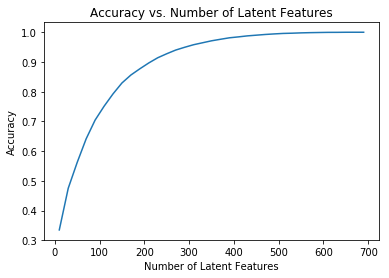

In [42]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

We can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data. 

In [43]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_articles - all of the test article ids
    
    '''
    # user-item matrix of the training dataframe
    user_item_train = create_user_item_matrix(df_train)
    # user-item matrix of the testing dataframe
    user_item_test = create_user_item_matrix(df_test)
    
    train_idx = set(df_train['user_id'].values)
    train_articles = set(df_train['article_id'].values)
    
    test_idx = set(df_test['user_id'].values)
    test_articles = set(df_test['article_id'].values)
    
    match_idx = list(train_idx.intersection(test_idx))
    match_articles = list(train_articles.intersection(test_articles))
    
    user_item_test = user_item_test.loc[match_idx, match_articles]
    
    return user_item_train, user_item_test, test_idx, test_articles

user_item_train, user_item_test, test_idx, test_articles = create_test_and_train_user_item(df_train, df_test)

In [44]:
print(user_item_test.shape[0])
print(len(test_idx)-user_item_test.shape[0])
print(user_item_test.shape[1])
print(len(test_articles)-user_item_test.shape[1])

20
662
574
0


In [45]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


#### Fit SVD

In [46]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

#### Get u_test, vt_test

In [47]:
#get u_test, vt_test 
user_idx = user_item_train.index.isin(test_idx)
articles_idx = user_item_train.columns.isin(test_articles)

u_test = u_train[user_idx, :]
vt_test = vt_train[:, articles_idx]

# Test data
train_idx = user_item_train.index
row_idxs_2 = user_item_test.index.isin(train_idx)
sub_user_item_test = user_item_test.loc[row_idxs_2]

#### Visualize accuracy vs Number of Latent Features

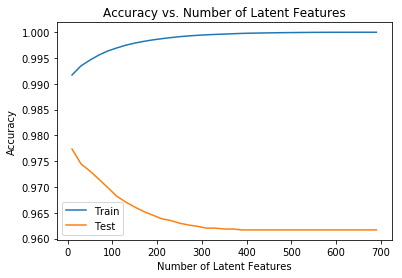

In [48]:
latent_feats = np.arange(10, 700+10, 20)

train_error, test_error = [], []


for k in latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    # compute prediction accuracy
    train_error.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    test_error.append(accuracy_score(sub_user_item_test.values.flatten(), user_item_test_preds.flatten()))


plt.figure()
plt.plot(latent_feats, train_error, label='Train')
plt.plot(latent_feats, test_error, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

**Visualization comments**

Looking at the graph, it can be observed that whilst training accuracy increases, testing accuracy decreases. This could be a result of the training model overfitting, causing it to predict the training dataset too well, even with latent features increasing. However, it can't perform with the same degree of accuracy on a different dataset, hence the drop in accuracy.

**Dataset comments**

There is a high possibility that due to the limited data, there is not enough overlap between users on article features. Having too many latent features with not that many article/user interactions makes it increasingly difficult for a model such as SVD to provide any meaningful insights. Models such as SVD can perform on bigger datasets.

**A/B testing**

In reality, for datasets of this size, A/B tests can be a successfull approach to provide recommendations. There is no time data to suggest an optimal length for conducting the experiment, however, that can be determined by gathering more knowledge on the user base from IBM. Once the experiment is underway, useful metrics may include tracking the traffic of users onto a recommendation and their retention on it, making sure that they do not only click on a title but also have the interest to spend time to read it. A 5-step user feedback system can be implemented to give further detail into the user preferences after making a recommendation. 


In [49]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0

### References

This workbook is built as part of a project submission for Udacity

SVD: [https://medium.com/the-andela-way/foundations-of-machine-learning-singular-value-decomposition-svd-162ac796c27d]
